In [91]:
# Import necessary libraries

import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

In [92]:
# Read data from CSV file and convert the timestamp column to datetime format

x = pd.read_csv("ETH_7D_graph_coinmarketcap.csv",delimiter=";")
x["timestamp"] = x['timestamp'].apply(lambda x : datetime.fromisoformat(x))
x = x.set_index("timestamp")

In [93]:
# Define parameters

timeframe_days = 31  # Number of days to consider
timeframe_hours = timeframe_days * 8  # Number of hours to consider based on timeframe_days
eth_borrowed = 0.1  # Amount of ETH borrowed for liquidity provision
lower_tick = 1876  # Lower tick value for the range
higher_tick = 1878  # Higher tick value for the range
pool_fees = 0.0005 # Fees of the simulated pool (0.05%)

eth_supplied = eth_borrowed #Amount to supply

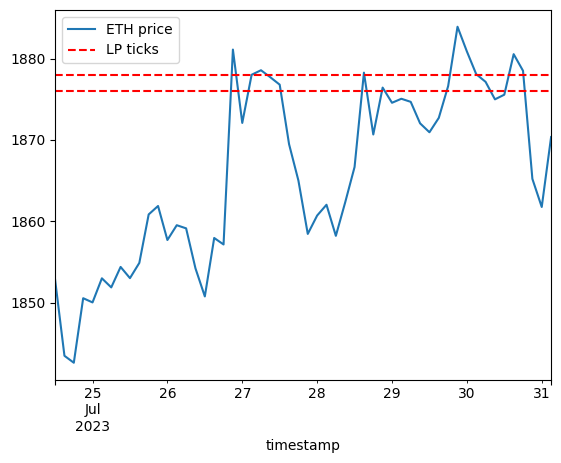

In [94]:
# Plot ETH price over the selected timeframe

eth_price = x["open"][-timeframe_hours:]
eth_price.plot(label="ETH price")
plt.axhline(lower_tick,linestyle="--",color = "r",label="LP ticks")
plt.axhline(higher_tick,linestyle="--",color = "r")
plt.legend()
plt.show()

In [95]:
# Create a DataFrame for ETH price data and determine enters and exits of the specified price range

df_eth_price = pd.DataFrame(eth_price)
enters_range = (df_eth_price["open"] >= lower_tick) & (df_eth_price["open"].shift(1)<lower_tick)
exits_range =  (df_eth_price["open"] <= higher_tick) & (df_eth_price["open"].shift(1)>higher_tick)
transitions = enters_range | exits_range
transitions = transitions.astype(int)*pool_fees

In [96]:
# Calculate the portfolio value, fees and LP value

ptf = pd.Series(dtype=float)

# The 'transitions' variable indicates whether Ether price visits the LP range 
# For each transition, LP accumulates 0.05% (0.005) of fees paid by traders 
# The fees are cumulatively added over time to track the total fees accumulated 
ptf["fees"] = (transitions*eth_borrowed*np.sqrt(lower_tick*eth_price)).cumsum()

# The LP value represents the liquidity position value in USDC at a given timestamp based on the price of ETH
# If the ETH price is below the lower tick the LP position is not active and it's only ETH
# If the ETH price is above the higher tick, the LP position is not actve and it's only USDC, the value is computed using uniswap constant product formula
# If the ETH price is within the range, the LP position is active and its value is computed using uniswap constant product formula 

ptf["LP value"] = eth_price.apply(lambda x: eth_supplied*x if x < lower_tick 
                                  else eth_supplied*np.sqrt(lower_tick*higher_tick) if x > higher_tick 
                                  else eth_supplied*(np.sqrt(lower_tick*x)))

# The liquidity provider borrows some ETH to provide liquidity
ptf["debt"] = eth_borrowed*eth_price

# The portfolio value is the difference between the LP value and the debt amount
ptf["ptf value"] = ptf["LP value"] - ptf["debt"]

# This is the gross impermanent loss as we don't take into account the fees
ptf["impermanent loss"] = ptf["LP value"]/ptf["debt"] - 1

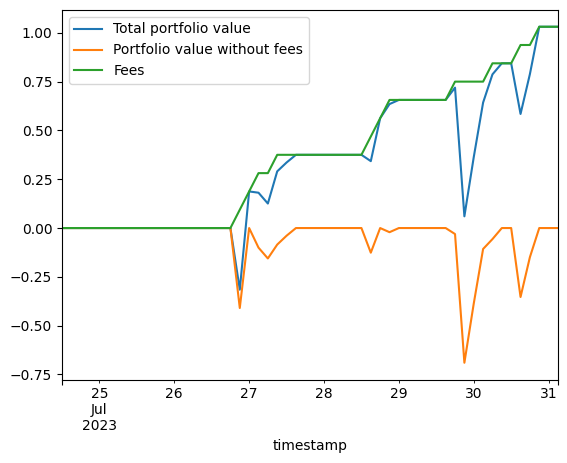

In [97]:
# Plot total portfolio value and its components

(ptf["ptf value"]+ptf["fees"]).plot(label="Total portfolio value")
(ptf["ptf value"]).plot(label="Portfolio value without fees")
(ptf["fees"].plot(label="Fees"))
plt.legend()
plt.show()

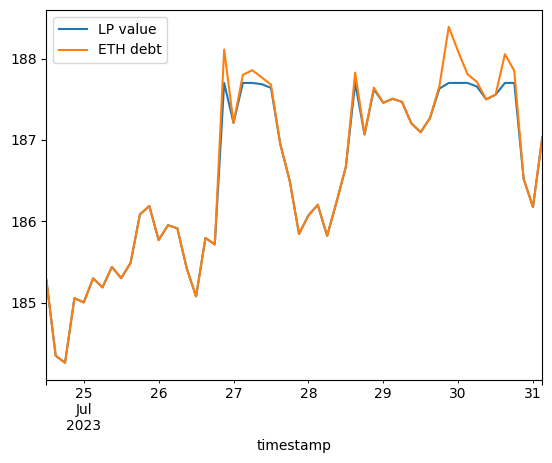

In [98]:
# Plot LP value and debt

(ptf["LP value"]).plot(label="LP value")
(ptf["debt"].plot(label="ETH debt"))
plt.legend()
plt.show()

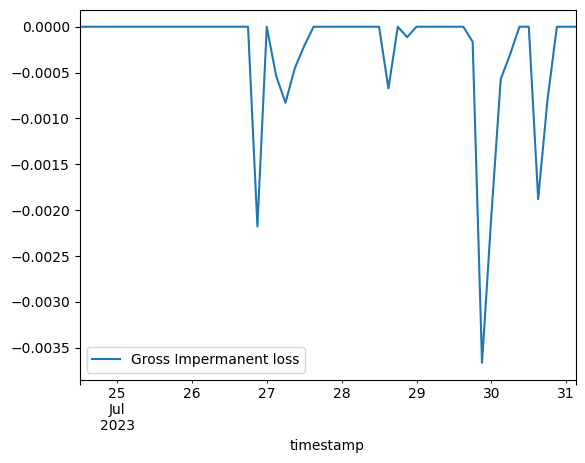

In [101]:
# Plot Impermanent loss

(ptf["impermanent loss"].plot(label="Gross Impermanent loss"))
plt.legend()
plt.show()

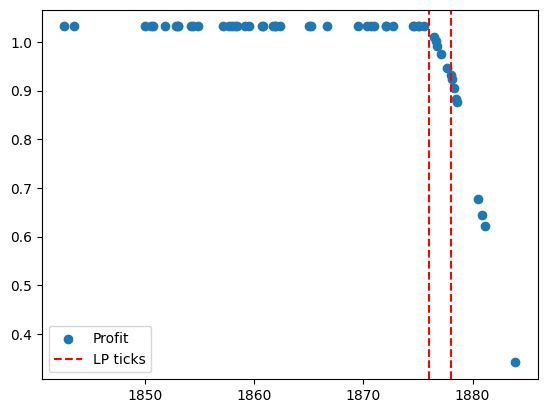

In [100]:
# Plot the payoff based on ETH price and total portfolio value at the end of the selected timeframe

plt.scatter(eth_price,ptf["ptf value"] + ptf["fees"][-1],label="Profit")
plt.axvline(lower_tick,linestyle="--",color = "r",label="LP ticks")
plt.axvline(higher_tick,linestyle="--",color = "r")
plt.legend()
plt.show()